In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp

import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
myhost = os.uname()[1]
if myhost == 'macmazzitelli.lnf.infn.it':
    mybasepath = '/Users/mazzitel/Dropbox/GR2/soft/data/'
    posix=False
else:
    mybasepath = '/workarea/cloud-storage/mazzitel/'
    posix=True
print("Host:", myhost)
print (sys.version, get_ipython())
if 'google.colab' in str(get_ipython()) and sys.version[0:1] in '2':
    mybasepath = './'
    posix=False
    print('Running on CoLab')

Welcome to JupyROOT 6.22/06
Host: f788a0b0dfb1
3.6.8 (default, Nov 16 2020, 16:55:22) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-44)] <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fd33a576668>


In [2]:
def Gauss3(x, a0, x0, s0):
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))
    
def histGaus(var, bins, ax, color='b', xrange=False, alpha=1, label=''):
    from sklearn.metrics import r2_score
    from scipy.stats import chisquare
    import scipy.stats as stats
    if xrange:
        ax.hist(var, bins=bins, label=label, color=color, range=(xrange[0], xrange[1]), alpha=alpha)
        y, bins_edge = np.histogram(var, bins=bins, range=(xrange[0], xrange[1]))
    else:
        ax.hist(var, bins=bins, label=label, color=color)
        y, bins_edge = np.histogram(var, bins=bins)
    p0=[y.max(),bins_edge[y.argmax()], var.std()]
    x = np.linspace(bins_edge[0], bins_edge[-1], bins)
    popt, pcov = curve_fit(Gauss3, x, y, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    r2=r2_score(y, Gauss3(x, *popt))
    x = np.linspace(bins_edge[0], bins_edge[-1], 100)
    sstat='a = {0:.2f} +/- {1:.2f}\nb = {2:.2f} +/- {3:.2f} \
    \nc = {4:.2f} +/- {5:.2f}\n$R^2$ = {6:.4f}'.format(popt[0], perr[0], popt[1], perr[1], 
                                                popt[2], perr[2], r2)
    ax.plot(x,Gauss3(x, *popt), color+'--', label=sstat)
    return ax
def ExpG(x, p0, p1, a0, x0, s0): # power of ten
    import numpy as np
    return p0*np.exp(p1*x) + a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def Exp(x, p0, p1): # power of ten
    import numpy as np
    return p0*np.exp(p1*x)

def G3(x, a0, x0, s0): # power of ten
    import numpy as np
    return a0 * np.exp(-(x - x0)**2 / (2 * s0**2))

def myExpG(data,ax, xmin, xmax, bins, E0, E1, a0, x0, s0):
    y = data[(data > xmin) & (data < xmax)]
    binsf = int(bins*((xmax-xmin)/(y.max()-y.min())))
    x=np.linspace(xmin , xmax, binsf)
    yh, _ = np.histogram(y, bins=binsf, range=(xmin,xmax))
    popt, pcov = curve_fit(ExpG, x, yh, 
                            p0=(E0, E1, a0, x0, s0))    
    #print ("Params: ", popt) 
    perr = np.sqrt(np.diag(pcov))
    #print ("err: ", perr)
    # plt.title(r'E0*$e^{(E1*x)}$ + a0*$e^{-\frac{(x - x0)^2}{2*s0^2}}$', fontsize=30)
    ax.plot(x, ExpG(x, *popt), 'r--', linewidth=2,
    label='E0 = %.2e +/- %.2e\nE1 = %.2e +/- %.2e\na0 = %.2e +/- %.2e\nx0 = %.2e +/- %.2e\ns0 = %.2e +/- %.2e' % 
                          (popt[0], perr[0],  popt[1],perr[1],
                           popt[2],perr[2], popt[3], perr[3], popt[4], perr[4]))
    ax.plot(x, G3(x, popt[2], popt[3], popt[4]), 'b-', label='signal')
    ax.plot(x, Exp(x, popt[0], popt[1]), 'y-', label='background')
    return ax




/workarea/cloud-storage/mazzitel/ped/run3965_mean.h5 /workarea/cloud-storage/mazzitel/ped/run3965_sigma.h5
light over Th: 15990228.46 
Open file: /workarea/cloud-storage/cygnus/Data/LAB/histograms_Run03957.root
Find Keys: 100
# of Images (TH2) Files: 100 
# of Waveform (TH2) Files: 0 
Camera X, Y pixel: 2048 2048 
>>>> Processing RUN:  3957 Event:  0
DEBUG: number of points, clusters: 981 92
['iTr: 0.00', 'cluster_lable: 92.00', 'pixels: 112.00', 'photons: 678.81', 'ph_pixels: 6.06', 'x0start: 1004.00', 'y0start: 1916.00', 'x0end: 1012.00', 'y0end: 1924.00', 'width: 9.75', 'height: 5.75', 'pearson: 0.48']


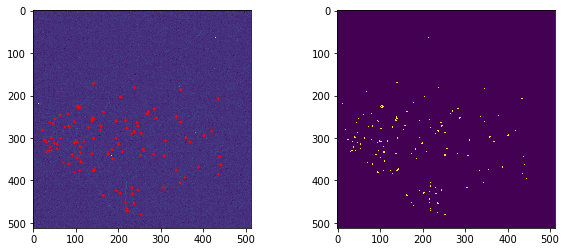

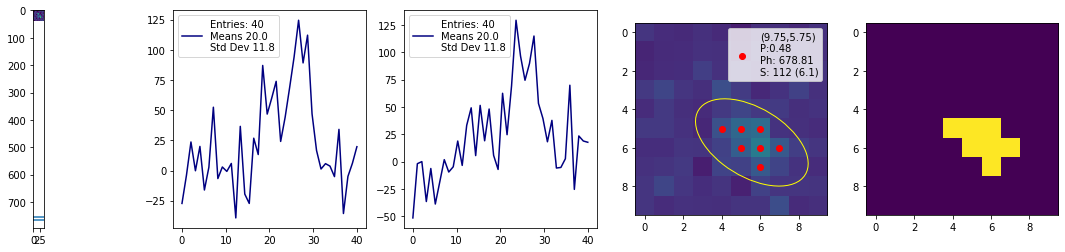

>>>> Processing RUN:  3957 Event:  10


KeyboardInterrupt: 

In [263]:
######################## INIT ###############################
runI          = [3957] #4061
run_ped       = 3965 #4062
#run_ped       = 4020
cimax         = 500
cimin         = 0 
tag           = 'LAB'
nsigma        = 1.5 
doRescale     = True
###############################################################
cfile = cy.open_(runI[0], tag=tag, posix=posix, verbose=False)
if cfile.x_resolution == 2048:
    rescale = 512 # orca flash
else:
    rescale = 576 #fusion

tscale = int(cfile.x_resolution/rescale)
if not doRescale: 
    rescale = cfile.x_resolution
    eps=5
    min_samples = 40
    
else:
    eps=2
    min_samples = 5


################################################################
debug         = False
columns = ["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]


######################### Load PED #############################

m_image, s_image = cy.ped_(run_ped, path=mybasepath+'ped/')

#########################

th_image   = np.round(m_image + nsigma*s_image)
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))

# loop sui fle da analizaare
for nRi in range(len(runI)):
    try:
        # open file
        cfile = cy.open_(runI[nRi], tag=tag, posix=posix, verbose=True)
    except:
        print ('Problem in open file: ', runI[nRi])
        break
    #
    # crea un db vuoto da riempire 
    df = pd.DataFrame(columns = columns)
    # crea nome file di output
    file_out = (mybasepath+"out/dbscan_run%d_cmin_%d_cmax_%d_rescale_%d_nsigma_%.1f_ev_%d_ped_%d.plk.gz" % 
                (runI[nRi], cimin, cimax, rescale, nsigma, cfile.max_image, run_ped))
    #
######## main loop sulle imagini da analizzare ###########
    for iTr in range(0, cfile.max_image): 
        if iTr % 10 == 0: 
          # running & debug ...
          print ('>>>> Processing RUN: ', runI[nRi], 'Event: ', iTr)
          # end 

        image = rtnp.hist2array(cfile.file.Get(cfile.pic[iTr])).T

        rebin_image     = cy.rebin(image-m_image, (rescale, rescale))  
        rebin_th_image  = cy.rebin((th_image-m_image), (rescale, rescale))

        edges           = (rebin_image > rebin_th_image) & (rebin_image < cimax)         
        points          = np.array(np.nonzero(edges)).T.astype(float) 
        
        # X_scaled        = StandardScaler().fit_transform(cy.poit_3d(points, rebin_image)) # 3D
        # dbscan          = DBSCAN(eps=0.045, min_samples = 20).fit(X_scaled) # eps=0.08 per 3D 0.04 2D
        
        dbscan          = DBSCAN(eps=eps, min_samples = min_samples).fit(points) 
        clusters        = dbscan.labels_
        n_points      = len(clusters>-1)
        
        for ic in range (min(clusters), max(clusters)+1):
            ph = 0.
            yc = points[:,0][clusters==ic]
            xc = points[:,1][clusters==ic]
            
            ph, dim = cy.cluster_par(xc, yc, rebin_image) 
            width, height, pearson = cy.confidence_ellipse_par(xc,yc)
            
            #
            # attenzine NORMALIZZAZIONE per per rscale
            #
            for j in range(0, dim):
                x=int(xc[j])
                y=int(yc[j])
                #ph += rebin_image[y,x]
                if j == 0:
                    x0start = x*tscale
                    y0start = y*tscale
            x0end = x*tscale
            y0end = y*tscale

            ph     = ph*tscale*tscale
            dim    = dim*tscale*tscale
            width  = width*tscale
            height = height*tscale
            
            # 
            # salva info per ogni cluster
            #
            df = df.append({columns[0]:iTr, columns[1]:ic, columns[2]:dim, columns[3]:ph, columns[4]:ph/dim, 
                            columns[5]:x0start, columns[6]:y0start, columns[7]:x0end, columns[8]:y0end, 
                            columns[9]:width, columns[10]:height, columns[11]:pearson},
                            ignore_index=True)
########### Debug  #####################################
        if iTr % 10 == 0 or debug:
            print ("DEBUG: number of points, clusters: " +str(n_points), ic) 
            print ([str(columns[i])+': {:.2f}'.format(x) for i, x in enumerate (df.tail(1).values[0])])
            fig, ax = plt.subplots(1,2, figsize=(10,4))
            ax[0].imshow(rebin_image, vmin=-5, vmax=30)
            yc = points[:,0][clusters>-1]
            xc = points[:,1][clusters>-1]
            ax[0].plot(xc,yc, 'r.', markersize=1, label="ic"+str(ic))
            ax[1].imshow(edges)
            plt.show()
            fig, ax = plt.subplots(1,5, figsize=(20,4))
            norma = int(image.shape[0]/rescale)
            #ic = 0
            yc = points[:,0][clusters==ic]
            xc = points[:,1][clusters==ic]

            dd  = int (20/tscale)
            zx1 = int(xc.mean() - dd)
            zx2 = int(xc.mean() + dd)
            zy1 = int(yc.mean() - dd)
            zy2 = int(yc.mean() + dd)
            izoom = image[zy1*norma:zy2*norma,zx1*norma:zx2*norma]-m_image[zy1*norma:zy2*norma,zx1*norma:zx2*norma]
            ax[0].imshow(izoom, vmin=-5, vmax=30)
            #ax[0].axhline(x0start-zx1)
            #ax[0].axhline(x0end-zx1)
            py = np.sum(izoom, axis=0)
            px = np.sum(izoom, axis=1)
            x = np.linspace(0, py.size, py.size)
            ax[1].plot(x,py, "navy", label='Entries: {:d}\nMeans {:.1f}\nStd Dev {:.1f}'.format(x.size, x.mean(), x.std()))
            ax[2].plot(x,px, "navy", label='Entries: {:d}\nMeans {:.1f}\nStd Dev {:.1f}'.format(x.size, x.mean(), x.std()))

            ax[3].imshow(rebin_image[zy1:zy2,zx1:zx2], vmin=-5, vmax=30)
            el_plt, el_par = cy.confidence_ellipse(xc-zx1, yc-zy1, ax[3], edgecolor='yellow')
#             ph, dim = cy.cluster_par(xc, yc, rebin_image)
#             width, height, pearson = cy.confidence_ellipse_par(xc, yc)
            ax[3].scatter(xc-zx1, yc-zy1, color='red', label = ('(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                    (width, height, pearson, ph, dim, ph/dim)))
            ax[4].imshow(edges[zy1:zy2,zx1:zx2])
            ax[1].legend()
            ax[2].legend()
            ax[3].legend()
            plt.show()
#################### close and save ################
    df.to_pickle(file_out, compression='gzip')
    print ("out file", file_out)

number of points, closters: 1075 95
99 95 112 914.8800000000001 8.168571428571429 1072 1840 1072 1848 6.620873566984697 9.174095770701511 -0.3150630189063022


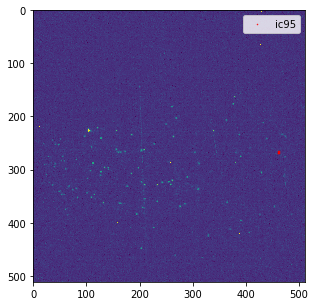

In [233]:
print ("number of points, closters: " +str(n_points), ic)
print(iTr, ic, dim, ph, ph/dim,x0start,y0start,x0end, y0end, width, height,pearson)
fig = plt.figure(figsize=(5,5))
plt.imshow(rebin_image, vmin=-5, vmax=30)
yc = points[:,1][clusters==ic]
xc = points[:,0][clusters==ic]
plt.plot(xc,yc, 'r.', markersize=1, label="ic"+str(ic))
plt.legend()
plt.show()

Ellipse(xy=(0, 0), width=2.202907820455146, height=1.774034141322415, angle=0) Ellipse(xy=(0, 0), width=2.202907820455146, height=1.774034141322415, angle=0)
10 3 9 84.59312500000001 2.202907820455146 1.774034141322415 0.21320071635561044
10 3 144 1353.4900000000002 8.811631281820585 7.09613656528966 0.21320071635561044


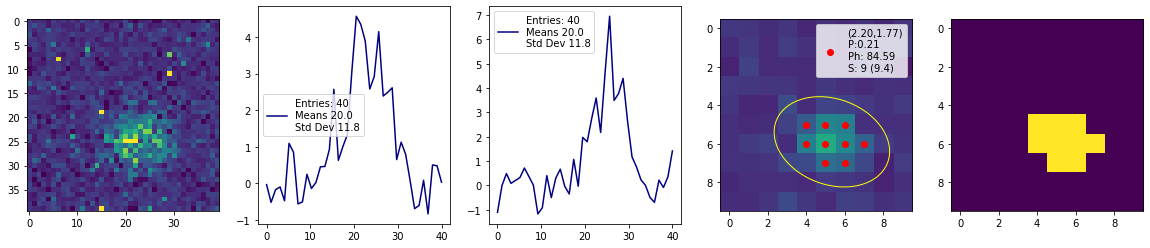

In [267]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
norma = int(image.shape[0]/rescale)
ic = 3
yc = points[:,0][clusters==ic]
xc = points[:,1][clusters==ic]

dd = 20/tscale
zx1 = int(xc.mean() - dd)
zx2 = int(xc.mean() + dd)
zy1 = int(yc.mean() - dd)
zy2 = int(yc.mean() + dd)
izoom = image[zy1*norma:zy2*norma,zx1*norma:zx2*norma]-m_image[zy1*norma:zy2*norma,zx1*norma:zx2*norma]

ax[0].imshow(izoom, vmin=-5, vmax=30)
py = np.mean(izoom, axis=0)
px = np.mean(izoom, axis=1)
x = np.linspace(0, py.size, py.size)
ax[1].plot(x,py, "navy", label='Entries: {:d}\nMeans {:.1f}\nStd Dev {:.1f}'.format(x.size, x.mean(), x.std()))
ax[2].plot(x,px, "navy", label='Entries: {:d}\nMeans {:.1f}\nStd Dev {:.1f}'.format(x.size, x.mean(), x.std()))

ax[3].imshow(rebin_image[zy1:zy2,zx1:zx2], vmin=-5, vmax=30)


el_plt, el_par = cy.confidence_ellipse(xc-zx1, yc-zy1, ax[3], edgecolor='yellow')
print(el_plt, el_par)
ph, dim = cy.cluster_par(xc, yc, rebin_image)
width, height, pearson = cy.confidence_ellipse_par(xc, yc)
ax[3].scatter(xc-zx1, yc-zy1, color='red', label = ('(%.2f,%.2f)\nP:%.2f\nPh: %.2f\nS: %d (%.1f)' %
                                    (width, height, pearson, ph, dim, ph/dim)))
ax[4].imshow(edges[zy1:zy2,zx1:zx2])

print(iTr, ic, dim, ph, width, height, pearson)

ph = ph*tscale*tscale
dim = dim*tscale*tscale
width = width*tscale
height = height*tscale
print(iTr, ic, dim, ph, width, height, pearson)


ax[1].legend()
ax[2].legend()
ax[3].legend()
plt.show()


In [339]:
def n_std_rectangle(x, y, ax, image = [], n_std=3.0, facecolor='none', **kwargs):
    from matplotlib.patches import Rectangle
    mean_x = x.mean()
    mean_y = y.mean()
    std_x = x.std()
    std_y = y.std()
    half_width = n_std * std_x
    half_height = n_std * std_y
    if image.any():
        rimage = image*0
        xs = int(mean_x - half_width)+1
        xe = int(mean_x + half_width)+1
        ys = int(mean_y - half_height)+1
        ye = int(mean_y + half_height)+1
        print(ys,ye, xs,xe)
        rimage[ys:ye, xs:xe]=image[ys:ye, xs:xe]
        print (rimage)
        print(rimage.sum())
        
    rectangle = Rectangle(
        (mean_x - half_width, mean_y - half_height),
        2 * half_width, 2 * half_height, facecolor=facecolor, **kwargs)
    return ax.add_patch(rectangle), rimage

scaled ph: 1353.5 dim: 144
15 33 11 33
[[ 0. -0. -0. ... -0.  0. -0.]
 [ 0.  0.  0. ...  0. -0. -0.]
 [ 0. -0.  0. ...  0.  0. -0.]
 ...
 [-0. -0.  0. ... -0.  0.  0.]
 [ 0. -0.  0. ... -0.  0. -0.]
 [ 0. -0. -0. ...  0.  0.  0.]]
1632.7600000000002


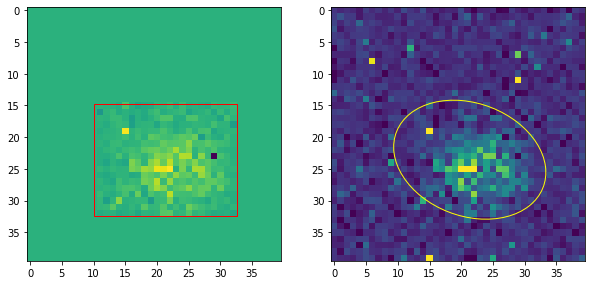

In [340]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(izoom, vmin=-5, vmax=30)
ax[1].imshow(izoom, vmin=-5, vmax=30)
el_plt, el_par = cy.confidence_ellipse((xc-zx1)*tscale, (yc-zy1)*tscale, ax[1], edgecolor='yellow')
ph, dim = cy.cluster_par(xc, yc, rebin_image)
print ("scaled ph: {:.1f} dim: {:d}".format(ph*tscale*tscale, dim*tscale*tscale))
_, rimage = n_std_rectangle((xc-zx1)*tscale, (yc-zy1)*tscale, ax[0], edgecolor='red', image=izoom)
ax[0].imshow(rimage)

# ax[0].axvline(20-el_par.height*tscale)
# ax[0].axvline(20+el_par.height*tscale)
# 
# ax[0].axhline(20-el_par.width*tscale)
# ax[0].axhline(20+el_par.width*tscale)

plt.show()

[[2.1 2.2]
 [3.1 3.2]]
[[0.  0.  0.  0. ]
 [0.  2.1 2.2 0. ]
 [0.  3.1 3.2 0. ]
 [0.  0.  0.  0. ]]


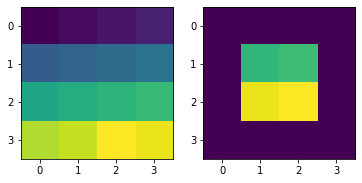

In [314]:
a = np.array([[1.0,1.1,1.2, 1.3], [2.0,2.1,2.2,2.3], [3.0,3.1,3.2,3.3], [4.0,4.1,4.4,4.3]])
b = a*0.

print (a[1:3, 1:3])
b[1:3, 1:3]=a[1:3, 1:3]
print (b)
fig, ax = plt.subplots(1,2)
ax[0].imshow(a)
ax[1].imshow(b)
plt.show()

In [278]:
dir(el_par.get_transform)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

# analisi

In [214]:
#
# carica i dati dal file
#
VarNames=["iTr", "cluster_lable", "pixels", "photons", "ph_pixels", "x0start", "y0start", 
          "x0end", "y0end", "width", "height", "pearson"]

#C_file = 'https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/dbscan_run2359_cmin_0_cmax_300_rescale_576_nsigma_1.5_ev_1000_ped_2358.txt'
#df = pd.read_csv(C_file, sep=" ", dtype='float64', names=VarNames)
try: 
    print("file"+file_out)
except NameError:
    file_out=mybasepath+"out/dbscan_run3957_cmin_0_cmax_500_rescale_2048_nsigma_1.5_ev_100_ped_3965.plk.gz"
    print("file"+file_out)
#file_out=mybasepath+"out/dbscan_run3957_cmin_0_cmax_500_rescale_2048_nsigma_1.5_ev_100_ped_3965.plk.gz"
#file_out=mybasepath+"out/dbscan_run3957_cmin_0_cmax_500_rescale_512_nsigma_1.5_ev_100_ped_3965.plk.gz"
df = pd.read_pickle(file_out, compression='gzip')

# range
# charge distribution
# charge asimettriy

df['length'] = np.sqrt((df['x0end'] - df['x0start'])**2 + (df['y0end'] - df['y0start'])**2)
df['x0c'] = (df['x0end'] + df['x0start'])/2.
df['y0c'] = (df['y0end'] + df['y0start'])/2.
df = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

file/workarea/cloud-storage/mazzitel/out/dbscan_run3957_cmin_0_cmax_500_rescale_512_nsigma_1.5_ev_100_ped_3965.plk.gz


In [215]:
df

,iTr,cluster_lable,pixels,photons,ph_pixels,x0start,y0start,x0end,y0end,width,height,pearson,length,x0c,y0c
1,0.0,0.0,144.0,772.56,5.365000,556.0,680.0,560.0,688.0,8.363148,7.619564,0.092848,8.944272,558.0,684.0
2,0.0,1.0,128.0,1107.35,8.651172,944.0,720.0,952.0,728.0,8.875203,7.016464,0.230769,11.313708,948.0,724.0
3,0.0,2.0,128.0,859.66,6.716094,1380.0,736.0,1388.0,744.0,8.000000,8.000000,0.000000,11.313708,1384.0,740.0
4,0.0,3.0,144.0,1638.78,11.380417,816.0,808.0,824.0,816.0,8.000000,8.000000,0.000000,11.313708,820.0,812.0
5,0.0,4.0,160.0,1512.15,9.450937,1732.0,824.0,1736.0,836.0,8.000000,8.000000,0.000000,12.649111,1734.0,830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10564,99.0,91.0,112.0,1013.55,9.049554,1480.0,1644.0,1484.0,1652.0,8.000000,8.000000,0.000000,8.944272,1482.0,1648.0
10565,99.0,92.0,96.0,707.10,7.365625,1624.0,1668.0,1624.0,1676.0,6.721344,9.100743,-0.294118,8.000000,1624.0,1672.0
10566,99.0,93.0,192.0,1979.30,10.308854,1320.0,1688.0,1320.0,1704.0,8.231815,7.761264,0.058793,16.000000,1320.0,1696.0
10567,99.0,94.0,128.0,1186.26,9.267656,812.0,1788.0,812.0,1796.0,6.531973,9.237604,-0.333333,8.000000,812.0,1792.0


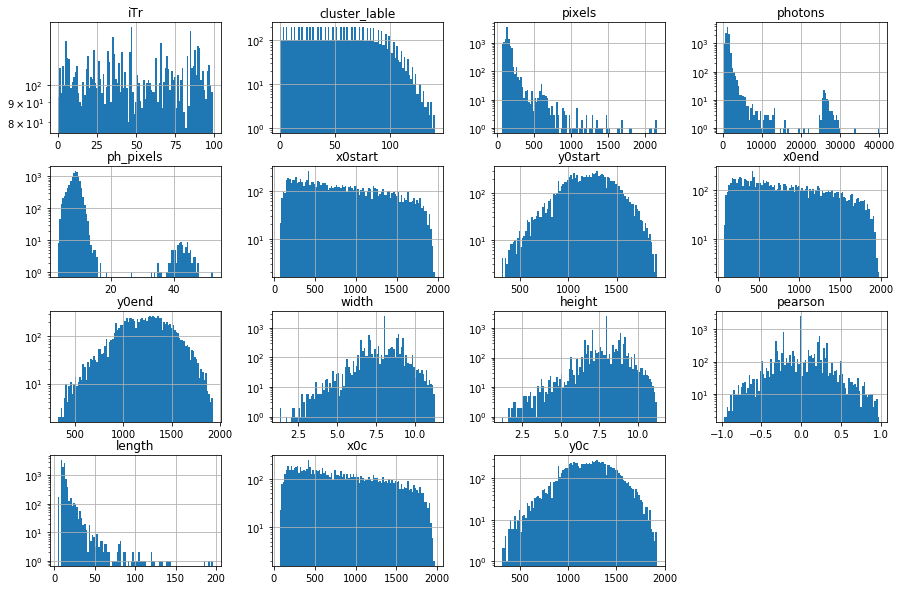

In [216]:
#
# Visulizza tutte le Varibili
#
df.hist(bins=100, figsize=(15,10), log=True)
plt.show()

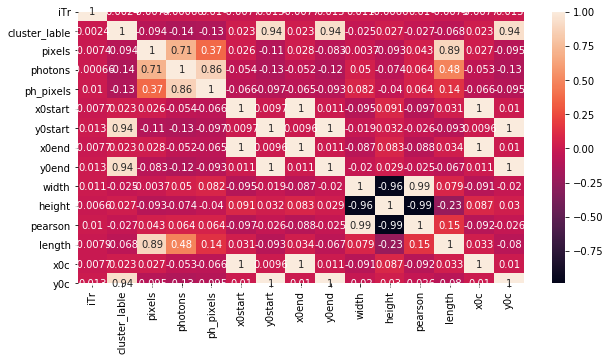

In [217]:
import seaborn as sns
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(), annot=True)
plt.show()

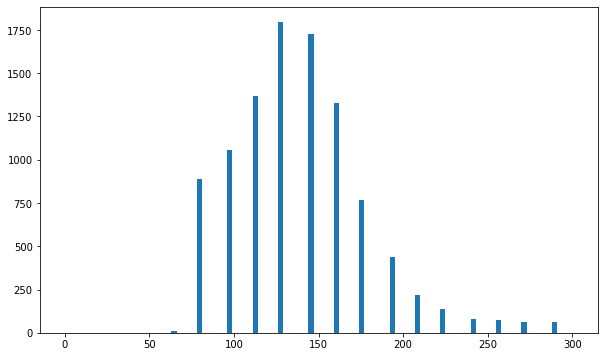

In [218]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.pixels, 100, range=(0,300))
#ax.set_yscale('log')
plt.show()

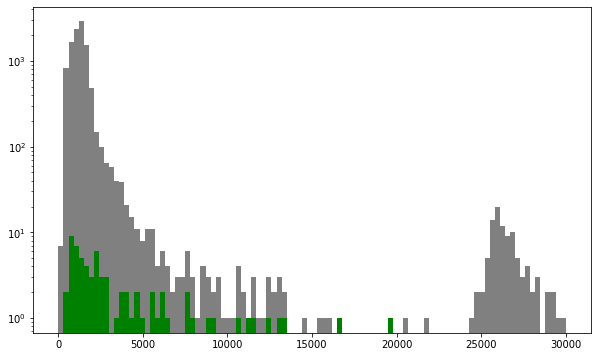

In [219]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.photons, 100, range=(0,30000), color="gray")
ax.hist(df.photons[df.pearson>0.8], 100, range=(0,30000), color="green")
ax.set_yscale('log')
plt.show()

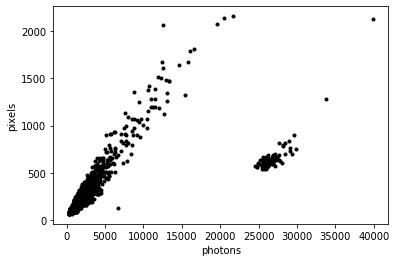

In [220]:
plt.plot(df.photons.values, df.pixels.values, 'k.')
plt.xlabel('photons')
plt.ylabel('pixels')
plt.show()

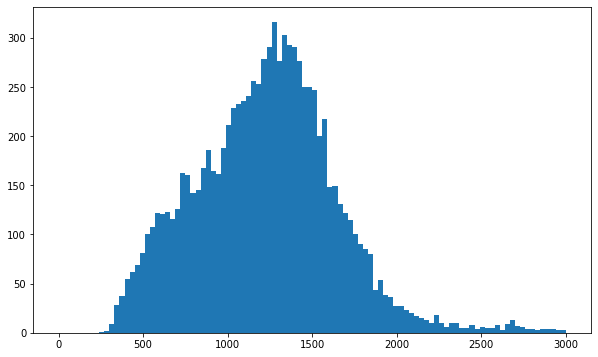

In [221]:
#
# Visualizziamo i fotoni
#
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df.photons[(df.pixels>40) & (abs(df.pearson)<0.5)], 100, range=(0,3000))
plt.show()

Fidical Ellips: 100.00, 120.00 [mm]


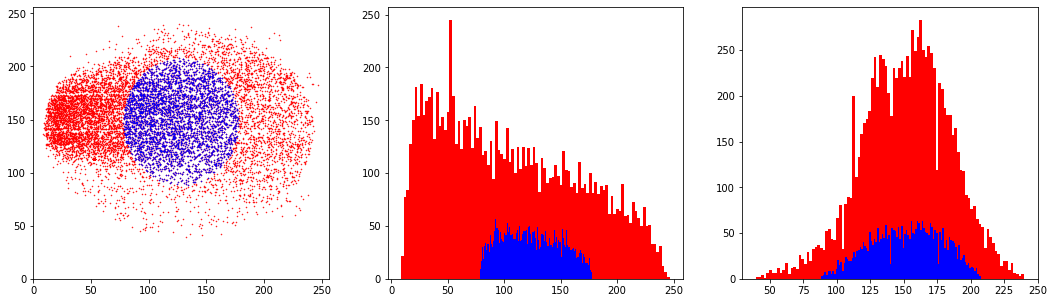

In [222]:
pd.set_option('mode.chained_assignment', None)
dfc = df[(df['cluster_lable'] > -1) & (df['width'] > 0) & (df['height'] > 0)]

# Normalization

phKev       = 2045.15/5.9
pixelscale  = 0.125 
x_resolution = y_resolution = 2048
xyscale = 1.
rescale_pixelscale = xyscale*pixelscale

dfc['photons']  =dfc['photons']*xyscale*xyscale
dfc['length']   =dfc['length']*rescale_pixelscale
dfc['x0c']      =dfc['x0c']*rescale_pixelscale
dfc['y0c']      =dfc['y0c']*rescale_pixelscale

# fiducializzation

DX = 0 
DY = -20
a = 100. # mm 
b = 120. # mm

a0 = a*0.5
b0 = b*0.5
#################################################


print ("Fidical Ellips: %.2f, %.2f [mm]" % (a,b))

d0 = x_resolution*pixelscale/2

fig, ax = plt.subplots(1,3, figsize=(18, 5))

y = dfc['y0c'].values
x = dfc['x0c'].values
x1 = x[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
y1 = y[((x-d0+DX)**2/a0**2 + (y-d0+DY)**2/b0**2 )< 1]
ax[0].plot(x, y, 'r.', markersize=1)
ax[0].plot(x1, y1, 'b.', markersize=1)
ax[0].set_xlim(0,256)
ax[0].set_ylim(0,256)
ax[1].hist(x, color='r',bins=100)
ax[1].hist(x1, color='b',bins=100)
ax[2].hist(y, color='r',bins=100)
ax[2].hist(y1, color='b',bins=100)
plt.show()

dfc = dfc[((dfc['x0c']-d0)**2/a0**2 + (dfc['y0c']-d0)**2/b0**2 )< 1]

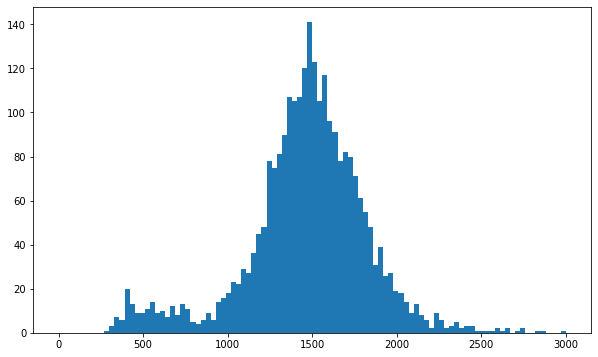

In [223]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(dfc.photons[(dfc.pixels>40) & (abs(dfc.pearson)<0.5)], 100, range=(0,3000))
plt.show()

/usr/local/lib64/python3.6/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


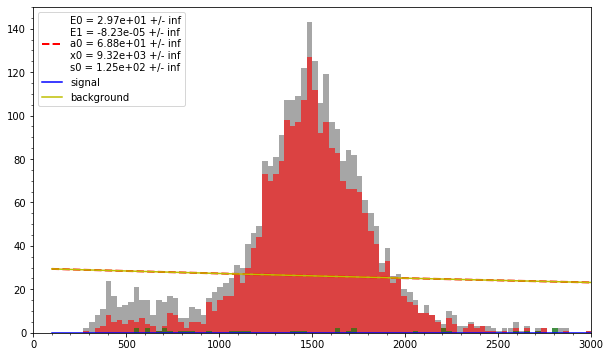

In [224]:
bins = 100

fig, ax = plt.subplots(figsize=(10,6))
hmax = 3000.
myExpG(dfc['photons'], ax, xmin=100., xmax=hmax, bins=100, E0=10000., E1=-0.001, a0=100., x0=2000., s0=300.)
ax.hist(dfc['photons'], bins=100, range=(0,hmax), color='gray', alpha=0.7)
ax.hist(dfc.photons[(dfc.pixels>40) & (abs(dfc.pearson)<0.3)], 100, range=(0,hmax), color="red", alpha=0.6)
ax.hist(dfc.photons[(dfc.pixels>40) & (abs(dfc.pearson)>0.8)], 100, range=(0,hmax), color="green", alpha=0.6)
ax.set_xlim(0,hmax)
#ax.set_yscale("log")
plt.legend(loc=2, prop={'size':'medium'})
plt.minorticks_on()
plt.show()

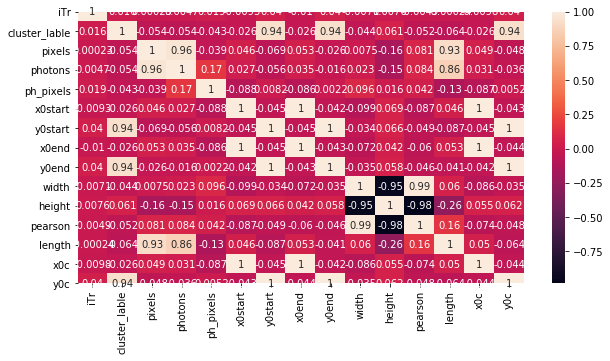

In [225]:
import seaborn as sns
plt.figure(figsize = (10,5))
sns.heatmap(dfc.corr(), annot=True)
plt.show()

In [226]:
258/1680

0.15357142857142858

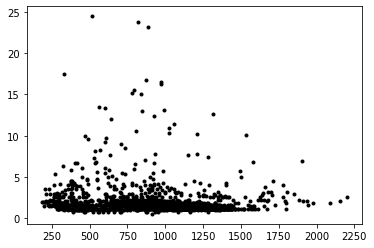

In [227]:
plt.plot(dfc.photons.values/dfc.length.values, dfc.length.values, 'k.')
plt.show()


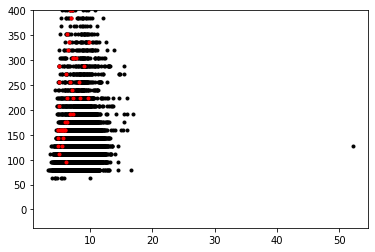

In [228]:
plt.plot(df.ph_pixels.values[df.photons<20000], df.pixels.values[df.photons<20000], 'k.')
plt.plot(df.ph_pixels.values[(df.pearson>0.8) & (df.photons<20000)], 
         df.pixels.values[(df.pearson>0.8) & (df.photons<20000)], 'r.')
plt.ylim(top=400)
plt.show()

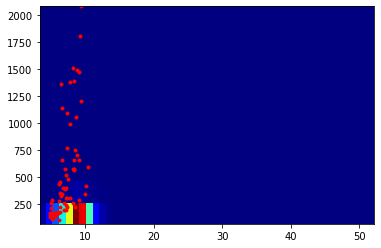

In [229]:
plt.hist2d(df.ph_pixels.values[df.photons<20000], df.pixels.values[df.photons<20000], bins=(50,10), cmap=plt.cm.jet)
plt.plot(df.ph_pixels.values[(df.pearson>0.8) & (df.photons<20000)], 
         df.pixels.values[(df.pearson>0.8) & (df.photons<20000)], 'r.')

plt.show()

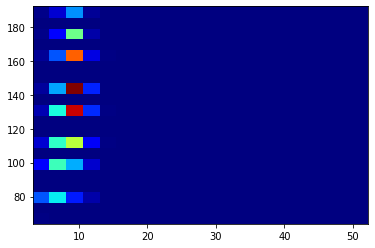

In [230]:
plt.hist2d(df.ph_pixels.values[(df.photons<20000) & (df.pixels<200)], 
           df.pixels.values[(df.photons<20000) & (df.pixels<200)], 
           bins=(20,20), cmap=plt.cm.jet)
plt.show()

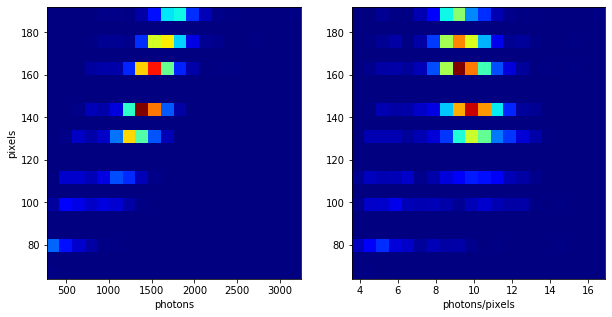

In [231]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist2d(dfc.photons.values[(dfc.pixels<200)], 
           dfc.pixels.values[(dfc.pixels<200)], 
           bins=(20,20), cmap=plt.cm.jet)
ax[0].set_xlabel("photons")
ax[0].set_ylabel("pixels")
ax[1].hist2d(dfc.ph_pixels.values[(dfc.pixels<200)], 
           dfc.pixels.values[(dfc.pixels<200)], 
           bins=(20,20), cmap=plt.cm.jet)
ax[1].set_xlabel("photons/pixels")
plt.show()

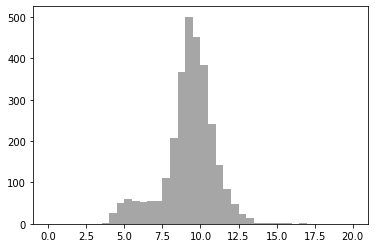

In [232]:
plt.hist(dfc['ph_pixels'], bins=40, range=(0,20), color='gray', alpha=0.7)
plt.show()